# 문제 개요

## 데이터 개략적 설명
Kaggle의 [Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/overview) 문제를 풀어봅시다.

- 본 문제는 주어진 Quora의 pair sentences가 중복된 내용인지 아닌지를 판별하는 문제입니다.
- 주어진 데이터 셋들 중 train set만 사용합니다.

## 접근 방향
- 다음 [논문](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8967103)에서 제시한  Siamese MaLSTM (‘‘Ma’’ for Manhattan distance) Neural Network model 구조를 구현한 코드입니다.

1. 2개의 서로다른 Input을 pre_trained embedding vectort(본 코드에서는 Glove 사용)로 바꿔줍니다.
2. 각 임베딩 벡터를 개별적으로 LSTM을 태운 후 도출된 벡터간 Manhattan Distance를 구합니다.
3. 해당 거리값에 대한 exp을 취해 0~1값으로 변형시켜준 후 label 값과 비교를 하여 loss를 구합니다.

![대체 텍스트](https://drive.google.com/uc?id=12UQ719zf9RolivaZQNas_fEJ3eOb82kV)


## 기본 세팅

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
PROJECT_ID = "python-note"
ROOT_DIR = "/content/drive/My Drive/Colab Notebooks/" + PROJECT_ID + "/"
DATA_DIR = ROOT_DIR + 'datasets/quora-question-pairs/'
IMAGES_DIR = DATA_DIR + 'images/'

print(ROOT_DIR, DATA_DIR, IMAGES_DIR, sep="\n")

/content/drive/My Drive/Colab Notebooks/python-note/
/content/drive/My Drive/Colab Notebooks/python-note/datasets/quora-question-pairs/
/content/drive/My Drive/Colab Notebooks/python-note/datasets/quora-question-pairs/images/


# EDA

In [4]:
# Quora question pairs : 데이터 분석
# ---------------------------------
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Quora question 데이터 읽어오기
data_df = pd.read_csv(DATA_DIR + 'train.csv')
data_df.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
train_que_list = pd.Series(data_df['question1'].tolist() + 
                      data_df['question2'].tolist()).astype(str)
train_que_list.head()

print('데이터의 총 질문 수: {}'.format(len(np.unique(train_que_list))))
print('반복해서 나타나는 질문의 개수: {}'.format(np.sum(train_que_list.value_counts() > 1)))


데이터의 총 질문 수: 537361
반복해서 나타나는 질문의 개수: 111873


In [9]:
train_que_list.value_counts()

What are the best ways to lose weight?                                             161
How can you look at someone's private Instagram account without following them?    120
How can I lose weight quickly?                                                     111
What's the easiest way to make money online?                                        88
Can you see who views your Instagram?                                               79
                                                                                  ... 
What is the best blog site for writers?                                              1
What are the best training institutes for VLSI in Mumbai?                            1
What disorders are more common in adult women than men?                              1
Which is better: being educated or being intelligent?                                1
Why did you buy Google Glass?                                                        1
Length: 537361, dtype: int64

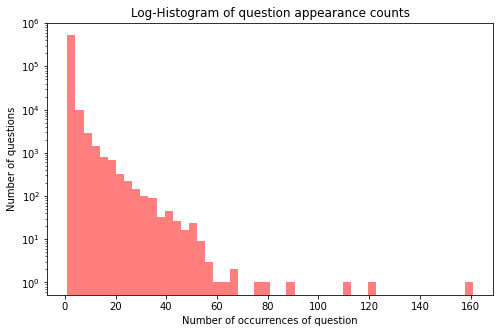

중복 최대 개수: 161
중복 최소 개수: 1
중복 평균 개수: 1.50
중복 표준편차: 1.91
중복 중간길이: 1.0
제 1 사분위 중복: 1.0
제 3 사분위 중복: 1.0


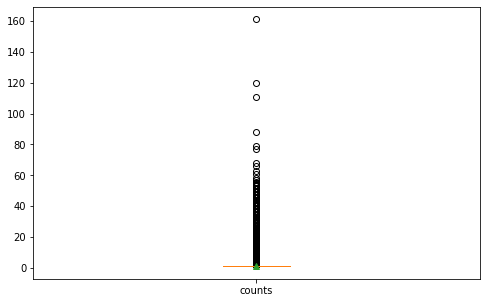

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(train_que_list.value_counts(), bins=50, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')
plt.show()

print('중복 최대 개수: {}'.format(np.max(train_que_list.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_que_list.value_counts())))
print('중복 평균 개수: {:.2f}'.format(np.mean(train_que_list.value_counts())))
print('중복 표준편차: {:.2f}'.format(np.std(train_que_list.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_que_list.value_counts())))
print('제 1 사분위 중복: {}'.format(np.percentile(train_que_list.value_counts(), 25)))
print('제 3 사분위 중복: {}'.format(np.percentile(train_que_list.value_counts(), 75)))

plt.figure(figsize=(8, 5))
plt.boxplot([train_que_list.value_counts()], labels=['counts'], showmeans=True)
plt.show()

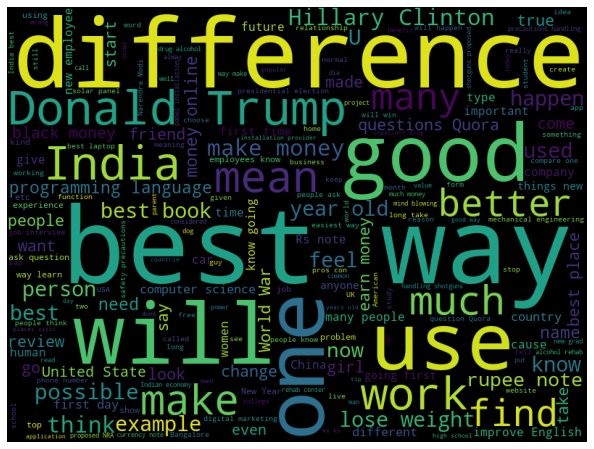

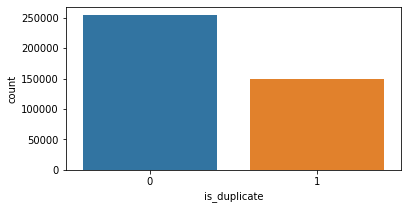

In [12]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_que_list.astype(str)))

plt.figure(figsize=(12, 8))
plt.imshow(cloud)
plt.axis('off')

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(data_df['is_duplicate'])

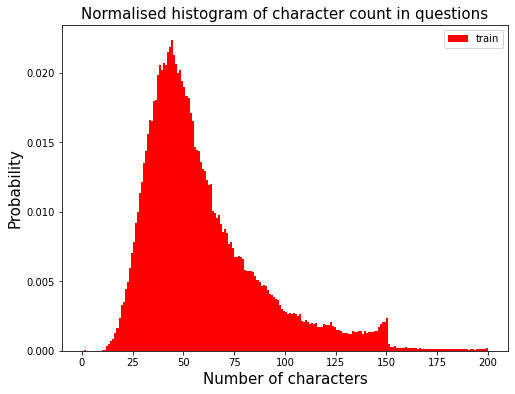

질문 길이 최대 값: 1169
질문 길이 평균 값: 59.82
질문 길이 표준편차: 31.96
질문 길이 중간 값: 51.0
질문 길이 제 1 사분위: 39.0
질문 길이 제 3 사분위: 72.0


In [13]:

train_length = train_que_list.apply(len)
plt.figure(figsize=(8, 6))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Normalised histogram of character count in questions", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

print('질문 길이 최대 값: {}'.format(np.max(train_length)))
print('질문 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('질문 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('질문 길이 중간 값: {}'.format(np.median(train_length)))
print('질문 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('질문 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))


질문 단어 개수 최대 값: 237
질문 단어 개수 평균 값: 11.06
질문 단어 개수 표준편차: 5.89
질문 단어 개수 중간 값: 10.0
질문 단어 개수 제 1 사분위: 7.0
질문 단어 개수 제 3 사분위: 13.0
질문 단어 개수 99 퍼센트: 31.0


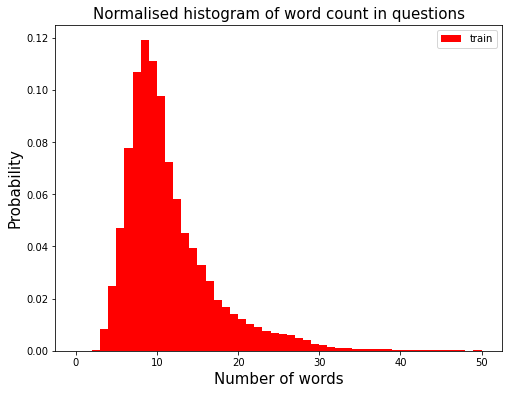

In [14]:

train_word_counts = train_que_list.apply(lambda x:len(x.split(' ')))
plt.figure(figsize=(8, 6))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('질문 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('질문 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('질문 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('질문 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('질문 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('질문 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('질문 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))




# Preprocessing

In [171]:
# Quora question pairs : 전처리
# -----------------------------
import pandas as pd
import numpy as np
import re
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import pickle

# Quora question 데이터 읽어오기
data_df = pd.read_csv(DATA_DIR + 'train.csv')
data_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## cleaning

In [172]:
# 간단히 전처리를 수행한다. FILTERS에 포함된 문자 제거, 소문자로 변환.
FILTERS = "([~.,!?\"':;)(])"
change_filter = re.compile(FILTERS)

questions1 = [str(s) for s in data_df['question1']]
questions2 = [str(s) for s in data_df['question2']]

filtered_questions1 = list()
filtered_questions2 = list()

for q in questions1:
     filtered_questions1.append(re.sub(change_filter, "", q).lower())
        
for q in questions2:
     filtered_questions2.append(re.sub(change_filter, "", q).lower())


In [173]:
# KERAS Tokenizer로 volcabulary를 구축하고 단어들을 워드 인덱스로 변환한다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_questions1 + filtered_questions2)
questions1_sequence = tokenizer.texts_to_sequences(filtered_questions1)
questions2_sequence = tokenizer.texts_to_sequences(filtered_questions2)
questions1_sequence[0]

[2, 3, 1, 1215, 57, 1215, 2573, 7, 569, 8, 756, 376, 8, 35]

In [174]:
# 한 문장의 길이는 31개로 제한한다.
MAX_SEQUENCE_LENGTH = 31
q1_np = pad_sequences(questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, 
                        padding='post', truncating='post')
q2_np = pad_sequences(questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, 
                        padding='post', truncating='post')
label_np = np.array(data_df['is_duplicate'], dtype=int)



In [207]:
print(q1_np.shape)
print(np.concatenate((q1_np, q2_np), axis=1).shape)

(404290, 31)
(404290, 62)


In [208]:
q_np = np.concatenate((q1_np, q2_np), axis=1)

In [209]:
# 전처리 결과를 저장해 둔다.
np.save(open(DATA_DIR + 'data_p_q1.npy', 'wb'), q1_np)
np.save(open(DATA_DIR + 'data_p_q2.npy', 'wb'), q2_np)
np.save(open(DATA_DIR + 'data_p_q.npy', 'wb'), q_np)
np.save(open(DATA_DIR + 'data_p_label.npy', 'wb'), label_np)

In [181]:
# 이렇게 vocab만들때는 train, test 모두 사용하여 만듦
with open(DATA_DIR + 'vocabulary.pickle', 'wb') as f:
    pickle.dump(tokenizer.word_index, f, pickle.HIGHEST_PROTOCOL)

# Model

In [39]:
import numpy as np
from sklearn.model_selection  import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle

In [156]:
# 전처리가 완료된 학습 데이터를 읽어온다.
q1_np = np.load(open(DATA_DIR + 'data_p_q1.npy', 'rb'))
q2_np = np.load(open(DATA_DIR + 'data_p_q2.npy', 'rb'))
q_np = np.load(open(DATA_DIR + 'data_p_q.npy', 'rb'))
label_np = np.load(open(DATA_DIR + 'data_p_label.npy', 'rb'))

train_p_df = pd.read_csv(DATA_DIR + 'data_p_df.csv')

# Quora 데이터의 Vocabulary를 읽어온다.
with open(DATA_DIR + 'vocabulary.pickle', 'rb') as f:
    word2idx = pickle.load(f)

## XGBOOST
우리가 만들 모델의 성능을 가늠하기 위한 비교군으로 XGBOOST 결과를 구해봅시다

In [ ]:
import numpy as np
from sklearn.model_selection  import train_test_split
import xgboost as xgb

In [ ]:
# question1과 question2를 concatenate한다.
# 이 부분은 책과 다르게 처리한다. 이유는 무엇인가?

q1_np = np.load(open(DATA_DIR + 'train_p_q1.npy', 'rb'))
q2_np = np.load(open(DATA_DIR + 'train_p_q2.npy', 'rb'))
label_np = np.load(open(DATA_DIR + 'train_p_label.npy', 'rb'))

train_input = np.hstack((q1_np, q2_np))

# 학습 데이터와 시험 데이터로 나눈다.
trainX, testX, trainY, testY = \
    train_test_split(train_input, label_np, 
                     test_size=0.2, random_state=4242)

In [ ]:
# XGBoost로 학습한다.
trainD = xgb.DMatrix(trainX, label = trainY)
testD = xgb.DMatrix(testX, label = testY)
data_list = [(trainD, 'train'), (testD, 'valid')]

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'binary:logistic',
    'eval_metric': 'rmse'}

model = xgb.train(params = param, dtrain = trainD, 
                  num_boost_round = 1000,
                  evals = data_list)

# 시험 데이터로 정확도를 계산한다
predY = model.predict(testD)
predY = np.where(predY > 0.5, 1, 0)
accuracy = (testY == predY).mean()
print()
print("* 시험용 데이터로 측정한 정확도 = %.2f" % accuracy)

[0]	train-rmse:0.492067	valid-rmse:0.492269
[1]	train-rmse:0.486796	valid-rmse:0.487092
[2]	train-rmse:0.482848	valid-rmse:0.483281
[3]	train-rmse:0.4791	valid-rmse:0.479612
[4]	train-rmse:0.476295	valid-rmse:0.476919
[5]	train-rmse:0.473707	valid-rmse:0.474331
[6]	train-rmse:0.471631	valid-rmse:0.472346
[7]	train-rmse:0.469765	valid-rmse:0.47051
[8]	train-rmse:0.467768	valid-rmse:0.468574
[9]	train-rmse:0.466313	valid-rmse:0.467176
[10]	train-rmse:0.464598	valid-rmse:0.465467
[11]	train-rmse:0.463415	valid-rmse:0.464281
[12]	train-rmse:0.462418	valid-rmse:0.463328
[13]	train-rmse:0.461506	valid-rmse:0.462468
[14]	train-rmse:0.460526	valid-rmse:0.461557
[15]	train-rmse:0.459729	valid-rmse:0.46081
[16]	train-rmse:0.458907	valid-rmse:0.45995
[17]	train-rmse:0.458202	valid-rmse:0.459249
[18]	train-rmse:0.457499	valid-rmse:0.458577
[19]	train-rmse:0.456739	valid-rmse:0.457842
[20]	train-rmse:0.45599	valid-rmse:0.457122
[21]	train-rmse:0.455542	valid-rmse:0.456665
[22]	train-rmse:0.455073	v

## maLSTM

In [116]:
# Quora question pairs : maLSTM 텍스트 유사도 모델
# -----------------------------------------------
import numpy as np
from sklearn.model_selection  import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [185]:
# 학습 데이터와 시험 데이터로 나눈다.
# sklearn의 함수를 이용하나, df를 나누기 위해 index를 넣고 이를 기반으로 df row를 선택함
train_idx, test_idx, y_train, y_test = train_test_split(data_p_df.index, data_p_df['is_duplicate'], 
                                                        test_size=0.2, stratify=label_np)
train_df =  data_p_df.iloc[train_idx]  # [['question1', 'question2']]  # return dataframe train

# X_train, X_test, y_train, y_test = \
#         train_test_split(q_np, label_np, test_size=0.2, stratify=label_np)

In [186]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398483,398483,2681,20514,"[2, 11, 26, 42, 356, 7, 367, 8, 989, 20, 3599,...","[2, 11, 1, 18, 221, 356, 7, 367, 8, 989, 2130,...",1
293084,293084,414795,414796,"[16, 9, 38, 2402, 500, 9064, 10, 10858, 50347,...","[3, 5552, 50347, 6, 206, 162, 0, 0, 0, 0, 0, 0...",0
216674,216674,6422,17411,"[2, 3, 1, 1452, 12, 4, 9, 1, 251, 963, 44, 169...","[2, 3, 1, 1452, 12, 4, 9, 1, 251, 963, 44, 169...",1
377288,377288,508562,508563,"[4, 13, 5, 348, 32, 184, 672, 7, 714, 2543, 20...","[4, 13, 5, 348, 32, 184, 672, 7, 714, 2543, 20...",0
204085,204085,43819,306886,"[4, 9, 5, 1073, 6, 599, 289, 0, 0, 0, 0, 0, 0,...","[4, 9, 5, 30, 107, 17, 599, 37, 1, 342, 2685, ...",1


### pre_trained word embedding 이용하기
- glove.6B.300d(Wikipedia 2014 + Gigaword 5 (6B tokens)를 활용

https://nlp.stanford.edu/projects/glove/

In [52]:
# maLSTM 모델을 빌드한다.
VOCAB_SIZE = len(word2idx) + 1
EMB_SIZE = 300         # pre-trained GloVe의 vector size = 300이므로, 이와 동일하게 맞춘다.

savedWeightEmbedding = True
if savedWeightEmbedding:
    # 저장된 WE를 읽어온다.
    with open(DATA_DIR + 'weightEmbedding.pickle', 'rb') as f:
        WE = pickle.load(f)
else:
    # Pre-trained GloVe 파일을 읽어와서 GloVe dictionary를 생성한다. 약 5분 정도 걸린다.
    file = open(ROOT_DIR + 'datasets/pre-trained/glove/glove.6B.300d.txt', encoding='utf-8')
    
    GloVe = {}
    for line in file:
        wv = line.split()
        word = ''.join(wv[:-EMB_SIZE])
        GloVe[word] = np.asarray(wv[-EMB_SIZE:], dtype=np.float32)
    file.close()
    # GloVe['love']을  실행하면 아래 vector가 출력된다. shape = (300,)
    # array([ 1.3949e-01,  5.3453e-01, -2.5247e-01, -1.2565e-01,  4.8748e-02,
    #         1.5244e-01,  1.9906e-01, -6.5970e-02,  1.2883e-01,  2.0559e+00, ...
    # 
    
    # Glove 사전 중 우리 데이터에 있는 단어들만 가져온다
    WE = np.zeros((VOCAB_SIZE, EMB_SIZE))
    for word, i in word2idx.items():
        vec = GloVe.get(word)
        if vec is not None:
            WE[i] = vec
    
    # 결과를 저장한다.
    with open(DATA_DIR + 'weightEmbedding.pickle', 'wb') as f:
        pickle.dump(WE, f, pickle.HIGHEST_PROTOCOL)


### Resample 
이것은 y의 비율을 안다는 가정 하에서 해주는 것이기에 train data에 대해서만 해주고 검증/테스트 set에 대해서는 해주면 안됨!

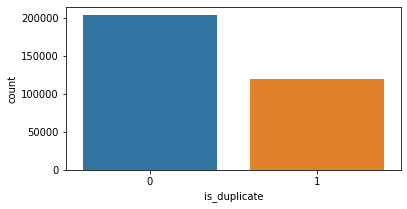

In [187]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_df['is_duplicate'])

심각한 수준은 아니나 label 데이터의 분포가 불균형하다. 이를 rebalancing 해보자

In [ ]:
# 중복된 페어와 중복되지 않은 페어로 분리한다.
train_dup_df = train_df.loc[train_df['is_duplicate'] == 1]
train_nodup_df = train_df.loc[train_df['is_duplicate'] == 0]

#### under sampling


In [ ]:
# 중복되지 않은 페어가 많으므로 둘의 비율이 비슷하도록 양을 조절한다.
# dample_frac (%) 만큼 샘플링
sample_frac = len(train_dup_df) / len(train_nodup_df)
print("before :", len(train_nodup_df), len(train_dup_df))

train_nodup_us_df = train_nodup_df.sample(frac = sample_frac)
print("after :", len(train_nodup_us_df), len(train_dup_df))

# 두 데이터를 다시 합친다
train_us_df = pd.concat([train_nodup_us_df, train_dup_df])

before : 255027 149263
after : 149263 149263


#### Over sampling

##### 직접 무작위 오버 샘플링 하기

In [ ]:
# 중복되지 않은 페어가 많으므로 둘의 비율이 비슷하도록 양을 조절한다.
# dample_frac (%) 만큼 샘플링
sample_frac =  len(train_nodup_df) / len(train_dup_df)
print("before :", len(train_nodup_df), len(train_dup_df))

train_dup_us_df = train_dup_df.sample(frac = sample_frac,  replace=True)
print("after :", len(train_nodup_df), len(train_dup_us_df))

# 두 데이터를 다시 합친다
train_os_df = pd.concat([train_nodup_df, train_dup_df])

before : 255027 149263
after : 255027 255027


##### SMOTE 기법 적용하기
동일한 데이터를 단순히 증식하는 방법은 overfitting되기에 의미가 없음   
-> 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식하는 SMOTE 같은 방법을 적용

SMOTE는 개별 데이터들의  K Nearest Nerghbor을 찾아서 이 데이터와 k개 이웃들의 차이를 일정 값으로 마들어 기존데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식임

그러나 이는 주로  numerical value에 적용되며 text에 적용은 하지 않는듯 함. [참고링크](https://datascience.stackexchange.com/questions/27671/how-do-you-apply-smote-on-text-classification)
- KNN will easily fail in those huge dimensions


텍스트 데이터에 대해서는 data augmentation 방식이 주로 쓰이며 다음과 같은 방식을 고려해볼 수 있음. [참고링크](https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8)
- tokenizing document into a sentence, 
- shuffling and rejoining them to generate new texts, 
- replacing adjectives, verbs etc by its a synonym to generate different text with the same meaning. Any pre-trained word embedding or NLTK’s wordnet can be used to find the synonym of a word.

In [ ]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(k_neighbors=1, random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X, df.labels) 

In [ ]:
from imblearn.over_sampling import SMOTE

print(q_np.shape)

smote = SMOTE(random_state=42)
q_os_np, label_os_np = smote.fit_resample(q_np, label_np)
print(q_os_np.shape)

(404290, 62)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [198]:
trainQ1 = q_os_np[:, :MAX_SEQUENCE_LENGTH]
trainQ2 = q_os_np[:, MAX_SEQUENCE_LENGTH:]

(510054, 31)

### Modeling

In [ ]:
HIDDEN_DIM = 128
FEATURE_DIM = 64
EMB_SIZE = 300  
REGULARIZER = 0.005

In [ ]:
# # 1. pre-trained 없이 해보기

# K.clear_session()
# inputQ1 = Input(batch_shape=(None, trainQ1.shape[1]))
# inputQ2 = Input(batch_shape=(None, trainQ2.shape[1]))

# embed_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)

In [58]:
# 2. pre-trained 이용해서 해보기

K.clear_session()
inputQ1 = Input(batch_shape=(None, trainQ1.shape[1]))
inputQ2 = Input(batch_shape=(None, trainQ2.shape[1]))

# 공통으로 사용할 Embedding layer
embed_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE,
                      weights = [WE], trainable = True)

In [55]:
# Question-1 처리용 LSTM
embQ1 = embed_layer(inputQ1)
embQ1 = Dropout(rate=0.2)(embQ1)
lstmQ1 = LSTM(HIDDEN_DIM)(embQ1)
lstmQ1 = Dense(FEATURE_DIM, activation='relu', 
               kernel_regularizer=regularizers.l2(REGULARIZER))(lstmQ1)
lstmQ1 = Dropout(rate=0.2)(lstmQ1)

# Question-2 처리용 LSTM
embQ2 = embed_layer(inputQ2)
embQ2 = Dropout(rate=0.2)(embQ2)
lstmQ2 = LSTM(HIDDEN_DIM)(embQ2)
lstmQ2 = Dense(FEATURE_DIM, activation='relu', 
               kernel_regularizer=regularizers.l2(REGULARIZER))(lstmQ2)
lstmQ2 = Dropout(rate=0.2)(lstmQ2)

# Question-1, 2의 출력으로 맨하탄 거리를 측정한다.
# lstmQ1 = lstmQ2 --> mDist = 1
# lstmQ1 - lstmQ2 = inf --> mDist = 0
# mDist = 0 ~ 1 사잇값이므로, trainY = [0, 1]과 mse를 측정할 수 있다.
mDist = K.exp(-K.sum(K.abs(lstmQ1 - lstmQ2), axis=1, keepdims=True))

model = Model([inputQ1, inputQ2], mDist)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0005))
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 300)      28462800    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 300)      0           embedding[0][0]       

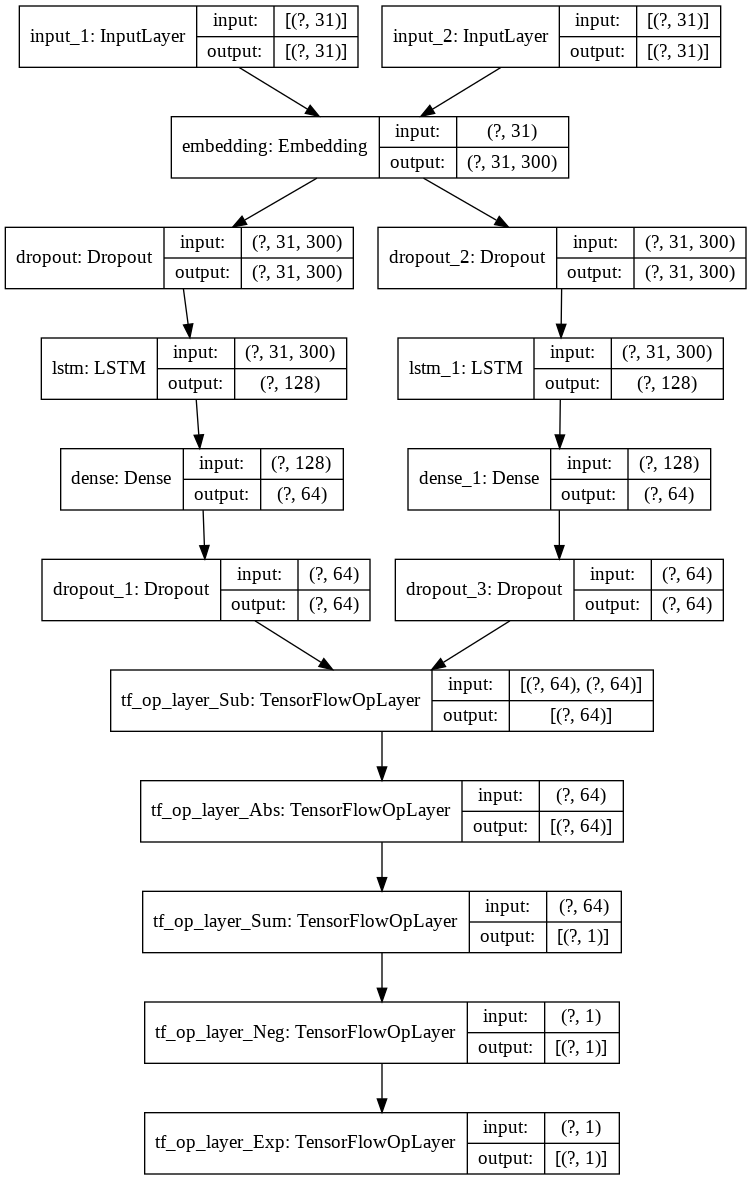

In [56]:
plot_model(model, 'model_comb.png', show_shapes=True)

In [60]:
# 학습
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#save_weights = ModelCheckpoint(f"{DATA_DIR}/p_{current_time}.hdf5", monitor='val_loss', save_best_only=True, save_freq='epoch', save_weights_only=True)


hist = model.fit([trainQ1, trainQ2], trainY,
                 validation_data = ([testQ1, testQ2], testY),
                 batch_size = 1000, epochs = 30,
                 shuffle=True, validation_split=0.2, callbacks=[early_stopping])  # , save_weights

Epoch 1/30
327/327 [==============================] - 17s 52ms/step - loss: 0.1502 - val_loss: 0.1650
Epoch 2/30
327/327 [==============================] - 17s 53ms/step - loss: 0.1476 - val_loss: 0.1604
Epoch 3/30
327/327 [==============================] - 17s 53ms/step - loss: 0.1457 - val_loss: 0.1568
Epoch 4/30
327/327 [==============================] - 17s 52ms/step - loss: 0.1426 - val_loss: 0.1593
Epoch 5/30
327/327 [==============================] - 17s 51ms/step - loss: 0.1406 - val_loss: 0.1604
Epoch 6/30
327/327 [==============================] - 17s 52ms/step - loss: 0.1377 - val_loss: 0.1561
Epoch 7/30
327/327 [==============================] - 17s 52ms/step - loss: 0.1357 - val_loss: 0.1521
Epoch 8/30
327/327 [==============================] - 17s 51ms/step - loss: 0.1337 - val_loss: 0.1530
Epoch 9/30
327/327 [==============================] - 17s 51ms/step - loss: 0.1314 - val_loss: 0.1577
Epoch 10/30
327/327 [==============================] - 17s 51ms/step - loss: 0.129

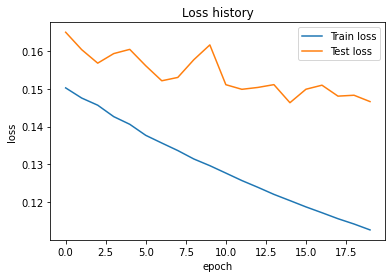


Accuracy = 79.32 %


In [62]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
predicted = model.predict([testQ1, testQ2])
predY = np.where(predicted > 0.5, 1, 0)
accuracy = (testY == predY).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))